In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

In [2]:
df = pd.read_csv('generated_data_decompressed/partitions_en_hdbscan_final.csv')

In [3]:
df.shape

(9701, 6)

In [4]:
df

,tweet_id,tweet,cleaned_tweets,partition,topic,cluster_size
0,1498720494102609920,@LAMStandley @ICRC Shut your stupid ass up bitch,shut stupid ass bitch,-1,[],3849
1,1499400883800395776,@Aih_News @ICRC You’re an ass,your ass,-1,[],3849
2,1497309239932452864,@PMaurerICRC @ICRC Fuck you... Send to straigh...,fuck send straight money ukrain compani total ...,-1,[],3849
3,1497674792169840640,@Kris_HK @cryptocom Yo. Red cross can go fuck ...,go fuck send money shit,-1,[],3849
4,1498624524857876480,@ejoftheweb @Caucasuswar @PhilipJTaylor1 @ICRC...,fuck pussi peopl fuck olimp stupid ue fuck nat...,-1,[],3849
...,...,...,...,...,...,...
9696,1489188173179768832,@pawanbishnoi722 @CandyLiis @Wilkmans @Euromai...,russian crap doesnt even allow go recov dead b...,238,"['russian', 'even', 'theyr', 'dead', 'putin', ...",5
9697,1505319868652040192,@The_Lookout_N Oh look how the Russian are evi...,oh look russian evil grant pow statu captur me...,238,"['russian', 'even', 'theyr', 'dead', 'putin', ...",5
9698,1497874816086462464,@redcross take Russian dead soldiers bodies fr...,russian dead soldier bodi ukrain back russia s...,238,"['russian', 'even', 'theyr', 'dead', 'putin', ...",5
9699,1497801782029815808,@RusEmbUSA @mfa_russia @USApoRusski @PentagonP...,bullshit russia prepar dont collect bodi dead ...,238,"['russian', 'even', 'theyr', 'dead', 'putin', ...",5


In [5]:
print(f'percentage of non clustered entries is: {np.round((df.partition==-1).sum() / df.shape[0], 2) * 100}%')

percentage of non clustered entries is: 40.0%


In [11]:
(df.partition==-1).sum()

3849

Text(0.5, 1.0, 'number of clusters for each cluster size')

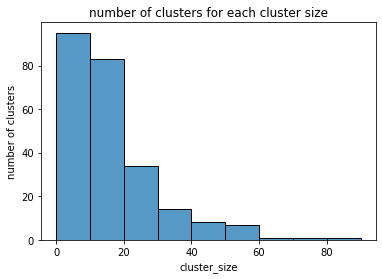

In [6]:
clusters = df[['partition', 'cluster_size', 'topic']].drop_duplicates().iloc[1:]
sns.histplot(clusters.cluster_size, bins=[i*10 for i in range (10)])
plt.ylabel('number of clusters')
plt.title('number of clusters for each cluster size')

In [12]:
def get_bool_one_kw_one_row(topics_list, needed_topic: str):
    if type(topics_list) is str:
        return needed_topic in  topics_list
    else:
        if len(topics_list)==0:
            return False
        else:
            return any([needed_topic in item for item in topics_list])

def get_topics_present_in_kw(df: pd.DataFrame, needed_topic: str):
    return df.loc[df.topic.apply(lambda x: get_bool_one_kw_one_row(x, needed_topic)), 'partition'].tolist()

* Get overview of topics and their repetitiveness in clusters:

In [13]:
tested_topics = ['gay', 'blood', 'homophob', 'russia', 'ukrain', 'steal']

test_dict = {}
for one_tested_topic in tested_topics:
    dict_one_topic = {}
    topics = get_topics_present_in_kw (clusters, one_tested_topic)
    dict_one_topic['topics_list'] = topics
    dict_one_topic['n_topics'] = len(topics)
    
    test_dict[one_tested_topic] = dict_one_topic

pd.DataFrame.from_dict(test_dict, orient='index')

,topics_list,n_topics
gay,[27],1
blood,"[27, 134, 127, 128]",4
homophob,[27],1
russia,"[89, 75, 243, 3, 29, 227, 194, 237, 15, 221, 2...",53
ukrain,"[153, 46, 89, 77, 75, 101, 201, 29, 208, 151, ...",52
steal,"[215, 18, 33]",3


In [21]:
def flatten(t):
    return [item for sublist in t for item in sublist]

from collections import Counter

counts = Counter(flatten(np.array(clusters.topic.apply(literal_eval))))

In [23]:
counts.most_common(40)

[('peopl', 52),
 ('ukrain', 43),
 ('like', 41),
 ('russia', 40),
 ('russian', 39),
 ('donat', 38),
 ('go', 38),
 ('fuck', 36),
 ('get', 35),
 ('kill', 34),
 ('putin', 33),
 ('dont', 27),
 ('stop', 22),
 ('money', 21),
 ('amp', 21),
 ('give', 16),
 ('know', 16),
 ('say', 15),
 ('civilian', 13),
 ('rule', 13),
 ('ukrainian', 13),
 ('world', 12),
 ('countri', 11),
 ('children', 11),
 ('your', 11),
 ('shit', 11),
 ('human', 11),
 ('terrorist', 10),
 ('help', 10),
 ('corrupt', 10),
 ('that', 10),
 ('bomb', 9),
 ('lie', 9),
 ('shoot', 9),
 ('make', 9),
 ('support', 9),
 ('crime', 9),
 ('would', 9),
 ('think', 9),
 ('call', 8)]